# Exploratory Data Analysis (EDA) and Data Preprocessing - Task 2

## Task 2: Fine-grained Misogyny Speech Detection

This task aims to predict the type of speech present in a phrase from a song. The categories are as follows:

- **Sexualization (S)**: Phrases that describe or suggest sexual acts, sexual language, or insinuations
- **Violence (V)**: Phrases referring to physical or verbal aggression, threats, or violent actions
- **Hate (H)**: Phrases containing offensive or discriminatory language, expressions of contempt, or hostility towards a group or individual.
- **Not Related (NR)**: Phrases that do not fall into the above categories and lack sexual, violent, or hateful content

### Examples:

- `ID_Track2, "S"` this song is defined as misogynistic, sexualization against women in the speech  
- `ID_Track2, "H"` this song is defined as misogynistic, hate against women in the speech

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
import os
import scattertext as st
import nlpaug.augmenter.word as naw
import torch

from wordcloud import WordCloud
from collections import Counter
from utils import *

In [ ]:
SUBTASK1_PATH = 'data'
SUBTASK2_PATH = 'new_data\subtask2'
SEED = 42

In [4]:
full_data = pd.read_csv(os.path.join(SUBTASK2_PATH, 'subtask2_train_rev002.csv'), encoding='utf-8')
full_data.set_index('id', inplace=True)
full_data

,lyrics,label
id,,
T2_TRAIN_0001,".\nQue no me falte tu cuerpo jamás, jamás\nNi ...",NR
T2_TRAIN_0002,"\n[Letra de ""Que Te Vaya Bonito""]\n\n[Verso 1]...",NR
T2_TRAIN_0003,\n[Coro:]\nAy me canse de rogarle (yo ah)\nAy ...,H
T2_TRAIN_0004,"\n[Letra de ""Te Conozco""]\n\n[Verso 1]\nTe con...",S
T2_TRAIN_0005,Letra subida por enriquembu\n\nSoy un hombre d...,NR
...,...,...
T2_TRAIN_1164,"t tickets as low as $39\n[Letra de ""Desesperad...",NR
T2_TRAIN_1165,s\nGuitarras lloren guitarras\nViolines lloren...,NR
T2_TRAIN_1166,y\nSoy un pobre caminante\nSin rumbo y sin dir...,NR


### EDA Part 1 - Raw data

In [7]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, T2_TRAIN_0001 to T2_TRAIN_1168
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  1168 non-null   object
 1   label   1168 non-null   object
dtypes: object(2)
memory usage: 59.7+ KB


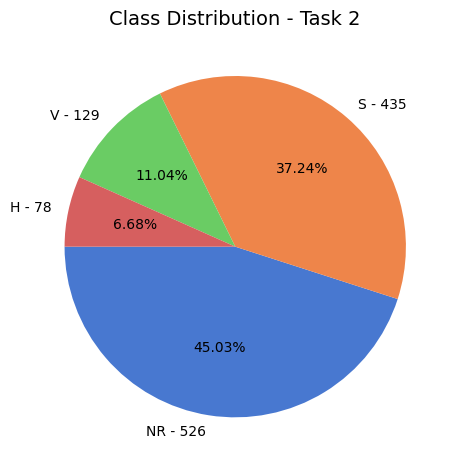

In [8]:
label_counts = full_data['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values
total = sizes.sum()
percentages = [f'{label} - {count}' for label, count in zip(labels, sizes)]

plt.pie(sizes, labels=percentages, autopct='%1.2f%%', startangle=180, colors=sns.color_palette('muted')) 
plt.title('Class Distribution - Task 2', fontsize=14)
plt.tight_layout()
plt.show()

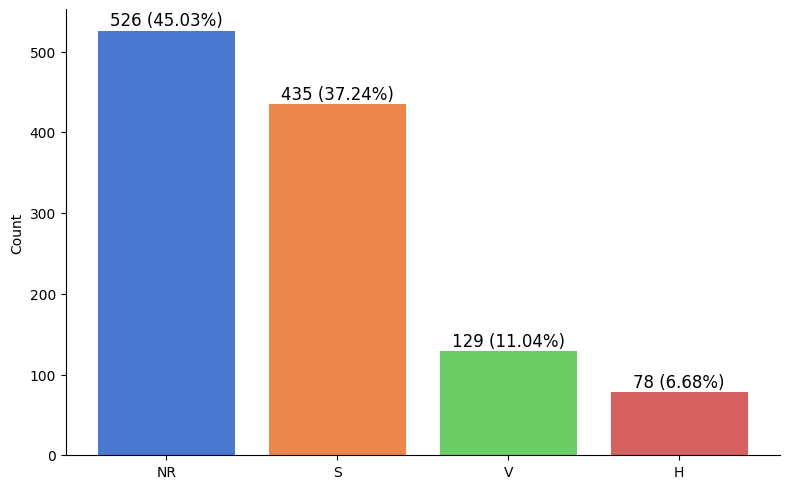

In [9]:
label_counts = full_data['label'].value_counts()
labels = label_counts.index
sizes = label_counts.values
total = sizes.sum()
percentages = [f'{count} ({count/total:.2%})' for label, count in zip(labels, sizes)]

colors = sns.color_palette('muted')

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, sizes, color=colors)

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, pct, ha='center', va='bottom', fontsize=12)



ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plt.title('Class Distribution - Task 2', fontsize=14)
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#### Character Length Distribution Analysis

In [10]:
stats = pd.DataFrame(index=full_data.index)

stats['label'] = full_data['label']
stats['char_length'] = full_data['lyrics'].apply(len)
stats['word_count'] = full_data['lyrics'].apply(lambda x: len(re.findall(r'\w+', x)))
stats.describe()

,char_length,word_count
count,1168.000000,1168.000000
mean,1902.380993,369.816781
std,1204.113820,233.549910
min,127.000000,26.000000
25%,1048.750000,202.000000
50%,1650.000000,320.000000
75%,2447.000000,475.250000
max,12950.000000,2495.000000


In [11]:
stats.groupby('label')[['char_length', 'word_count']].mean()

,char_length,word_count
label,,
H,1905.269231,366.538462
NR,1409.332700,273.792776
S,2447.701149,476.245977
V,2072.178295,404.449612


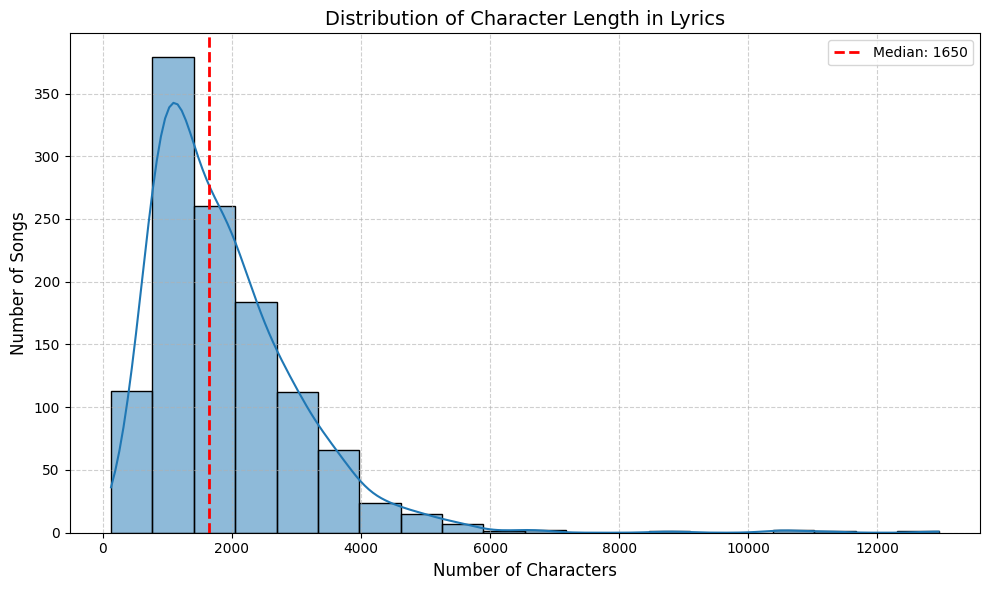

In [12]:
median_val_char = stats['char_length'].median()

plt.figure(figsize=(10, 6))
sns.histplot(stats['char_length'], bins=20, kde=True, edgecolor='black')
plt.axvline(median_val_char, color='red', linestyle='--', linewidth=2, label=f'Median: {median_val_char:.0f}')
plt.title('Distribution of Character Length in Lyrics', fontsize=14)
plt.xlabel('Number of Characters', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\sebas\AppData\Local\Temp\ipykernel_30108\2156366255.py:2: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.boxplot(x='label', y='char_length', hue='label', data=stats, legend=False, palette=sns.color_palette('muted')) # , palette='pastel'


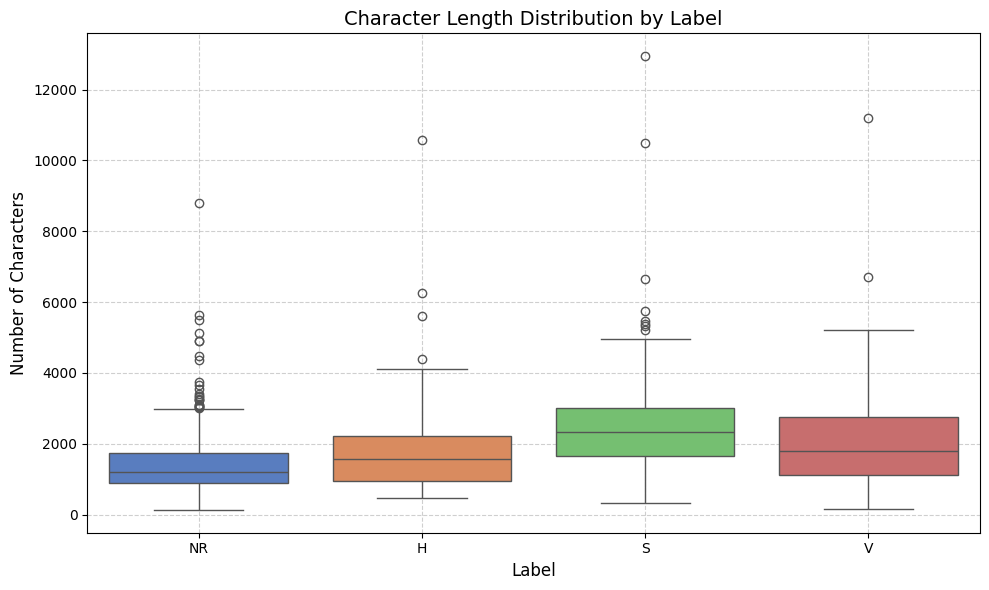

In [13]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='char_length', hue='label', data=stats, legend=False, palette=sns.color_palette('muted')) # , palette='pastel'
plt.title('Character Length Distribution by Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Characters', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### Word Length Distribution Analysis

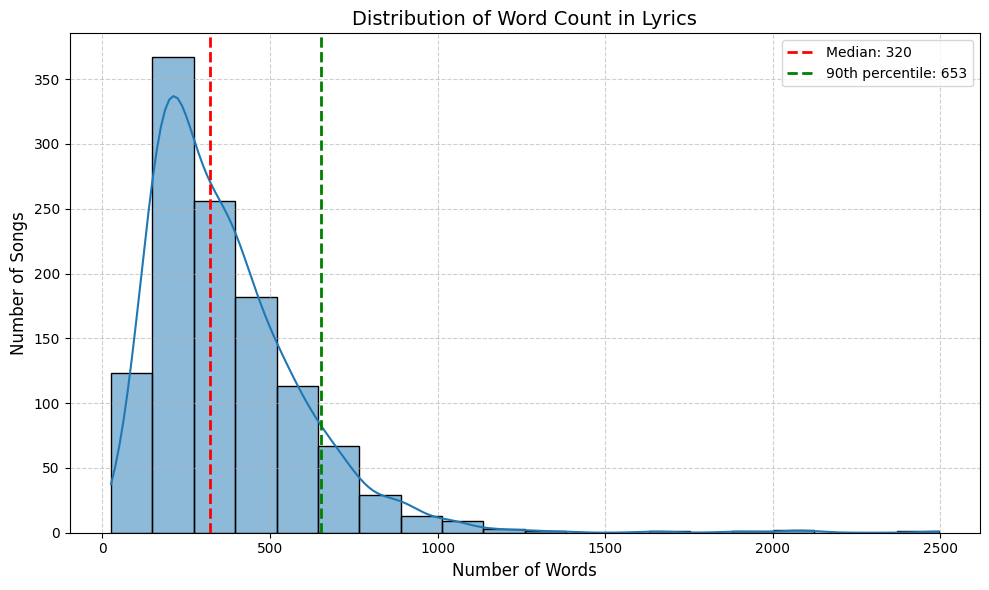

In [15]:
# Median and 90th percentile for word count
median_val_word = stats['word_count'].median()
p90_val_word    = np.percentile(stats['word_count'], 90)

plt.figure(figsize=(10, 6))
sns.histplot(stats['word_count'], bins=20, kde=True, edgecolor='black')

plt.axvline(median_val_word,
            color='red', linestyle='--', linewidth=2,
            label=f'Median: {median_val_word:.0f}')

plt.axvline(p90_val_word,
            color='green', linestyle='--', linewidth=2,
            label=f'90th percentile: {p90_val_word:.0f}')

plt.title('Distribution of Word Count in Lyrics', fontsize=14)
plt.xlabel('Number of Words', fontsize=12)
plt.ylabel('Number of Songs', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


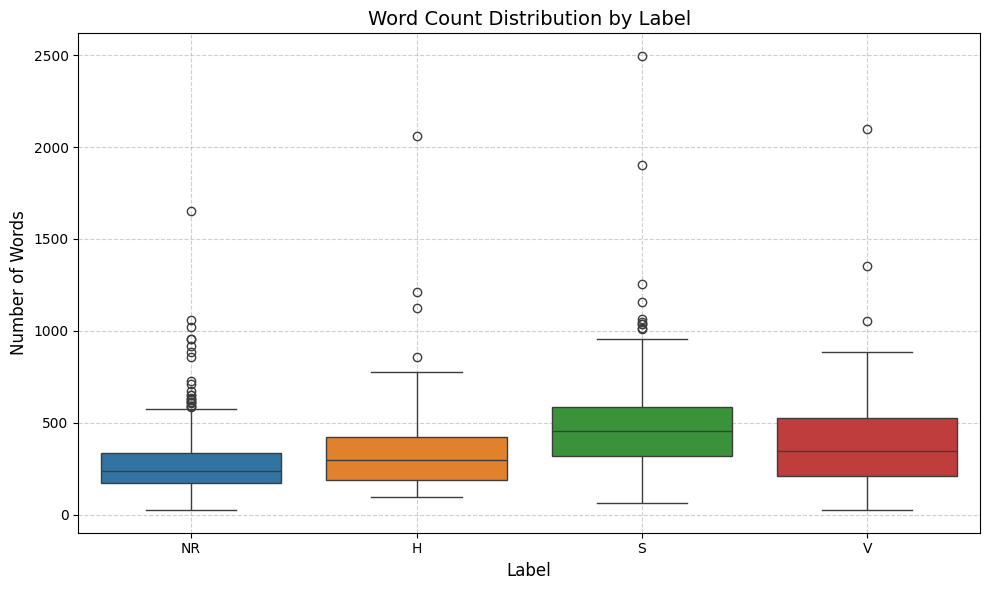

In [16]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='word_count', hue='label', data=stats, dodge=False)
plt.title('Word Count Distribution by Label', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Words', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Data Preparation

In [ ]:
language = 'spa'
model_type = 'ml'
stemming = False
lemmatization = False
remove_duplicates = True
cased = False # Keep cased for DL models
return_str = True

file_name = f"subtask2_train_clean_lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}.csv"
file_path = os.path.join(SUBTASK2_PATH, file_name)
vocabulary = 'lyrics'

# Check if file exists, otherwise preprocess and save
if os.path.exists(file_path):
    full_data = pd.read_csv(file_path, encoding='utf-8', index_col='id')
    print(f"Loaded cached preprocessed file: {file_path}")
else:
    full_data['lyrics_clean_ml'] = full_data[vocabulary].apply(
        lambda x: text_preprocess(
            x,
            lang=language,
            model_type=model_type,
            stem=stemming,
            lemmatize=lemmatization,
            remove_duplicates=remove_duplicates,
            cased=cased,
            return_str=return_str
        )
    )
    full_data.to_csv(file_path, encoding='utf-8', index=True)
    print(f"Saved cleaned data to: {file_path}")

Loaded cached preprocessed file: new_data\subtask2\subtask2_train_clean_lang_spa_model_ml_stem_False_lem_False_dup_True_cased_False.csv


In [19]:
full_data.head()

,lyrics,label,lyrics_clean_ml
id,,,
T2_TRAIN_0001,".\nQue no me falte tu cuerpo jamás, jamás\nNi ...",NR,falte cuerpo jamás jamás calor forma amar jamá...
T2_TRAIN_0002,"\n[Letra de ""Que Te Vaya Bonito""]\n\n[Verso 1]...",NR,ojalá vaya bonito ojalá acaben penas digan exi...
T2_TRAIN_0003,\n[Coro:]\nAy me canse de rogarle (yo ah)\nAy ...,H,canse rogarle canse decirle aja cansé rogarle ...
T2_TRAIN_0004,"\n[Letra de ""Te Conozco""]\n\n[Verso 1]\nTe con...",S,conozco pelo punta pies roncas noches duermes ...
T2_TRAIN_0005,Letra subida por enriquembu\n\nSoy un hombre d...,NR,letra subida enriquembu hombre divertido trist...


## EDA Part 2 - Clean Data

#### Frequent Words in Non-Misogynistic Lyrics

**Not Related (NR)**: Phrases that do not fall into the above categories and lack sexual, violent, or hateful content

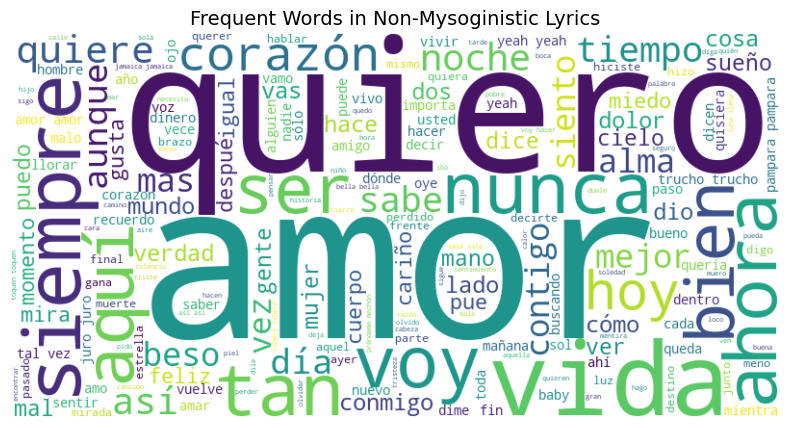

In [20]:
non_mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'NR']['lyrics'])
non_mysoginistic_lyrics_cl = text_preprocess(non_mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(non_mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Non-Mysoginistic Lyrics", fontsize=14)
plt.show()

In [21]:
word_counts_nms = Counter(non_mysoginistic_lyrics_cl.split())
top_words_nms = word_counts_nms.most_common(10)

pd.DataFrame(top_words_nms, columns=["Word", "Frequency"])

,Word,Frequency
0,amor,988
1,quiero,764
2,vida,611
3,voy,436
4,siempre,345
5,ahora,310
6,vez,304
7,corazón,304
8,así,291
9,nunca,271


#### Frequent Words in Mysoginistic Lyrics

**Sexualization (S)**: Phrases that describe or suggest sexual acts, sexual language, or insinuations

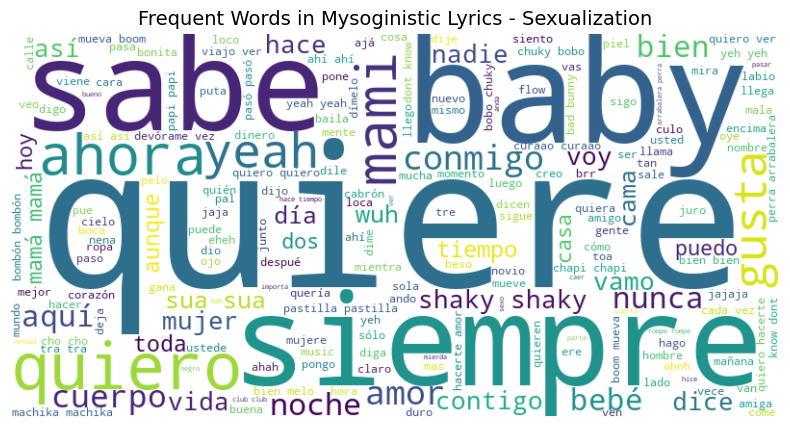

In [22]:

mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'S']['lyrics'])
mysoginistic_lyrics_cl = text_preprocess(mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Mysoginistic Lyrics - Sexualization", fontsize=14)
plt.show()

In [23]:
word_counts_ms = Counter(mysoginistic_lyrics_cl.split())    
top_words_ms = word_counts_ms.most_common(10)

pd.DataFrame(top_words_ms, columns=["Word", "Frequency"])

,Word,Frequency
0,quiero,1020
1,baby,558
2,amor,514
3,bien,491
4,siempre,479
5,quiere,432
6,gusta,426
7,mami,403
8,ahora,368
9,voy,363


**Violence (V)**: Phrases referring to physical or verbal aggression, threats, or violent actions

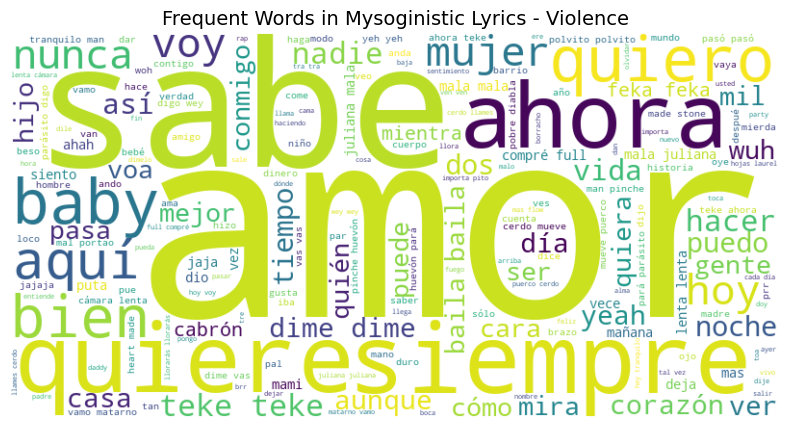

In [24]:

mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'V']['lyrics'])
mysoginistic_lyrics_cl = text_preprocess(mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Mysoginistic Lyrics - Violence", fontsize=14)
plt.show()

In [25]:
word_counts_ms = Counter(mysoginistic_lyrics_cl.split())    
top_words_ms = word_counts_ms.most_common(10)

pd.DataFrame(top_words_ms, columns=["Word", "Frequency"])

,Word,Frequency
0,amor,139
1,ahora,137
2,quiero,135
3,vida,122
4,nunca,106
5,dime,100
6,siempre,97
7,así,93
8,baby,93
9,vas,91


**Hate (H)**: Phrases containing offensive or discriminatory language, expressions of contempt, or hostility towards a group or individual.

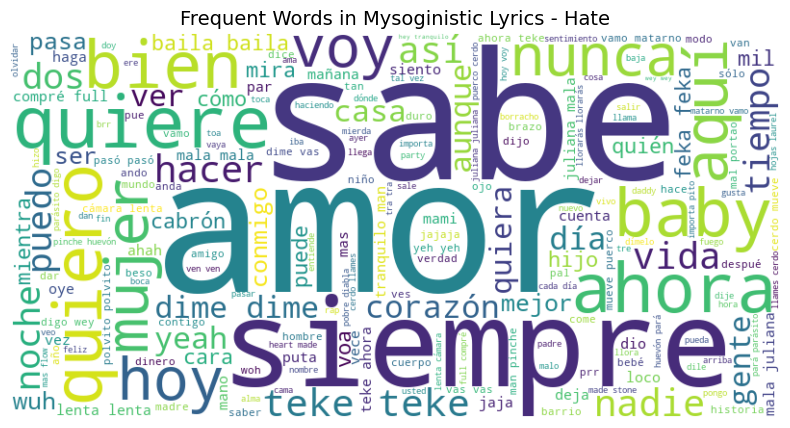

In [26]:
mysoginistic_lyrics_str = "\n".join(full_data[full_data['label'] == 'V']['lyrics'])
mysoginistic_lyrics_cl = text_preprocess(mysoginistic_lyrics_str, lang='spa', model_type='ml', stem=False, lemmatize=False, remove_duplicates = False, return_str=True)

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(mysoginistic_lyrics_cl)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Frequent Words in Mysoginistic Lyrics - Hate", fontsize=14)
plt.show()

In [27]:
word_counts_ms = Counter(mysoginistic_lyrics_cl.split())    
top_words_ms = word_counts_ms.most_common(10)

pd.DataFrame(top_words_ms, columns=["Word", "Frequency"])

,Word,Frequency
0,amor,139
1,ahora,137
2,quiero,135
3,vida,122
4,nunca,106
5,dime,100
6,siempre,97
7,así,93
8,baby,93
9,vas,91


#### Word Frequency Analysis with Scattertext 

In [28]:
new_full_data = full_data[['lyrics_clean_ml', 'label']].reset_index(drop=True)

new_data_S_V = new_full_data[(new_full_data['label'] == 'S') | (new_full_data['label'] == 'V')]
new_data_S_H = new_full_data[(new_full_data['label'] == 'S') | (new_full_data['label'] == 'H')]
new_data_H_V = new_full_data[(new_full_data['label'] == 'H') | (new_full_data['label'] == 'V')]

##### Sexualisation Vs. Violence 

In [ ]:
nlp = spacy.load('es_dep_news_trf') 
# corpus
corpus = st.CorpusFromPandas(
    new_data_S_V,
    category_col='label',
    text_col='lyrics_clean_ml',
    nlp=nlp
).build()

# Get top 500 terms (by total frequency)
term_freq_df = corpus.get_term_freq_df()
term_freq_df['total'] = term_freq_df.sum(axis=1)
top_500_terms = term_freq_df['total'].nlargest(500).index.tolist()

# Remove all other terms from the corpus
corpus_pruned = corpus.remove_terms(set(corpus.get_terms()) - set(top_500_terms))

html = st.produce_scattertext_explorer(
    corpus_pruned,
    category='S',
    category_name='Sexualisation',
    not_category_name='Violence',
    width_in_pixels=1250,
    metadata=new_data_S_V['label']
)

# Save HTML
with open("objects\\task_2\\Images\\task2_top500_freq_terms_S_V.html", 'wb') as f:
    f.write(html.encode('utf-8'))

##### Sexualisation Vs. Hate 

In [ ]:
nlp = spacy.load('es_dep_news_trf') 
corpus = st.CorpusFromPandas(
    new_data_S_H,
    category_col='label',
    text_col='lyrics_clean_ml',
    nlp=nlp
).build()

term_freq_df = corpus.get_term_freq_df()
term_freq_df['total'] = term_freq_df.sum(axis=1)
top_500_terms = term_freq_df['total'].nlargest(500).index.tolist()
corpus_pruned = corpus.remove_terms(set(corpus.get_terms()) - set(top_500_terms))

html = st.produce_scattertext_explorer(
    corpus_pruned,
    category='S',
    category_name='Sexualisation',
    not_category_name='Hate',
    width_in_pixels=1250,
    metadata=new_data_S_H['label']
)

with open("objects\\task_2\\Images\\task2_top500_freq_terms_S_H.html", 'wb') as f:
    f.write(html.encode('utf-8'))

##### Hate Vs. Violence 

In [ ]:
nlp = spacy.load('es_dep_news_trf') 
corpus = st.CorpusFromPandas(
    new_data_H_V,
    category_col='label',
    text_col='lyrics_clean_ml',
    nlp=nlp
).build()

term_freq_df = corpus.get_term_freq_df()
term_freq_df['total'] = term_freq_df.sum(axis=1)
top_500_terms = term_freq_df['total'].nlargest(500).index.tolist()
corpus_pruned = corpus.remove_terms(set(corpus.get_terms()) - set(top_500_terms))

html = st.produce_scattertext_explorer(
    corpus_pruned,
    category='H',
    category_name='Hate',
    not_category_name='Violence',
    width_in_pixels=1250,
    metadata=new_data_H_V['label']
)

with open("objects\\task_2\\Images\\task2_top500_freq_terms_H_V.html", 'wb') as f:
    f.write(html.encode('utf-8'))

## Data Augmentation

We are going to use the same augmented data that we created for subtask 1. The reason: task 2 dataset is a subset of task 1 dataset.


In [4]:
original_data_t2 = pd.read_csv(os.path.join(SUBTASK2_PATH, 'subtask2_train_rev002.csv'), encoding='utf-8')
original_data_t2.rename(columns={'label': 'label_t2', 'id':'id_t2'}, inplace=True)
original_data_t2.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1168 entries, 0 to 1167
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id_t2     1168 non-null   object
 1   lyrics    1168 non-null   object
 2   label_t2  1168 non-null   object
dtypes: object(3)
memory usage: 27.5+ KB


In [13]:
original_data_t2

,id_t2,lyrics,label_t2
0,T2_TRAIN_0001,".\nQue no me falte tu cuerpo jamás, jamás\nNi ...",NR
1,T2_TRAIN_0002,"\n[Letra de ""Que Te Vaya Bonito""]\n\n[Verso 1]...",NR
2,T2_TRAIN_0003,\n[Coro:]\nAy me canse de rogarle (yo ah)\nAy ...,H
3,T2_TRAIN_0004,"\n[Letra de ""Te Conozco""]\n\n[Verso 1]\nTe con...",S
4,T2_TRAIN_0005,Letra subida por enriquembu\n\nSoy un hombre d...,NR
...,...,...,...
1163,T2_TRAIN_1164,"t tickets as low as $39\n[Letra de ""Desesperad...",NR
1164,T2_TRAIN_1165,s\nGuitarras lloren guitarras\nViolines lloren...,NR
1165,T2_TRAIN_1166,y\nSoy un pobre caminante\nSin rumbo y sin dir...,NR
1166,T2_TRAIN_1167,\n[Intro]\nEl amor de mi vida\nEres y serás si...,NR


**Importante**: algunos parrafos estan escritos en ingles, esto confirma la elección de utilizar un modelo multilingue como **MDBERTA**

Define the augmented dataset that we want to retrieve. All new files subtask1 (from seccond review) are a subsample of subtask 1.

In [14]:
# Configuration parameters
language = 'spa'
model_type = 'dl'
stemming = False
lemmatization = False
remove_duplicates = True
cased = True  # Keep cased for DL models

data_config = f"lang_{language}_model_{model_type}_stem_{stemming}_lem_{lemmatization}_dup_{remove_duplicates}_cased_{cased}"
file_name = 'subtask1_all_aug' 
db_file_name = f"{file_name}_{data_config}.csv"
file_path = os.path.join(SUBTASK1_PATH, db_file_name)

if os.path.exists(file_path):
    aug_data_subt1 = pd.read_csv(file_path, encoding='utf-8')
    # aug_data_subt1.drop(columns=['lyrics'], inplace=True)
    aug_data_subt1 = aug_data_subt1[aug_data_subt1['augmentation_type'] != 'synonym_replacement']
    aug_data_subt1.rename(columns={'id': 'id_t1', 'label': 'label_t1'}, inplace=True)    
    print("File found:")
    print(aug_data_subt1.info())
else:
    raise FileNotFoundError(f"File not found at {file_path}")


File found:
<class 'pandas.core.frame.DataFrame'>
Index: 10520 entries, 0 to 12623
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id_t1              10520 non-null  object
 1   lyrics             10520 non-null  object
 2   label_t1           10520 non-null  object
 3   augmentation_type  10520 non-null  object
 4   is_augmented       10520 non-null  bool  
 5   lyrics_clean       10520 non-null  object
dtypes: bool(1), object(5)
memory usage: 503.4+ KB
None


In [15]:
aug_data_subt1['augmentation_type'].value_counts()

augmentation_type
original              2104
back_translation      2104
back_translation_2    2104
aeda_1                2104
aeda_2                2104
Name: count, dtype: int64

In [16]:
len(original_data_t2)

1168

In [17]:
merged_data_t2_1 = pd.merge(aug_data_subt1, original_data_t2, how='inner', on='lyrics')[['id_t1', 'id_t2', 'label_t2']] 
# merged_data_t2_1 # 1168 rows
# Now with the correct id
merged_data_t2_2 = pd.merge(aug_data_subt1, merged_data_t2_1, how='inner', on='id_t1')[['id_t2', 'label_t2', 'lyrics', 'lyrics_clean', 'augmentation_type', 'is_augmented']] 
merged_data_t2_2.rename(columns={'id_t2': 'id', 'label_t2': 'label'}, inplace=True) 

aug_data_t2_file_path = os.path.join(SUBTASK2_PATH, db_file_name.replace('subtask1', 'subtask2'))

merged_data_t2_2.to_csv(aug_data_t2_file_path, encoding='utf-8', index=False)
print(f"Saved augmented data to: {aug_data_t2_file_path}")

Saved augmented data to: new_data\subtask2\subtask2_all_aug_lang_spa_model_dl_stem_False_lem_False_dup_True_cased_True.csv


In [30]:
merged_data_t2_2['augmentation_type'].value_counts()

augmentation_type
original              1168
back_translation      1168
back_translation_2    1168
aeda_1                1168
aeda_2                1168
Name: count, dtype: int64